/Users/mrrobot/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Attempting to load counts from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/counts_matrix_raw.csv.gz
Attempting to load metadata from: /Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset/data/processed/cell_metadata_basic.csv

Successfully loaded counts_df and basic_metadata_df.
counts_df shape: (23459, 12346)
basic_metadata_df shape: (12346, 3)

Successfully created AnnData object.
AnnData object with n_obs × n_vars = 12346 × 23459
    obs: 'sample_type_prefix', 'tissue_origin', 'patient_id'

Made var_names (gene names) unique.

--- Attempting to identify mitochondrial genes and calculate QC metrics ---
`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/mrrobot/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")



Successfully calculated QC metrics.
First 5 rows of adata.obs (cell metadata with QC metrics):
            sample_type_prefix tissue_origin patient_id  n_genes_by_counts  \
NTH10-0616A                NTH   Normal_Lung      0616A               3572   
NTH11-0616A                NTH   Normal_Lung      0616A               3748   
NTH15-0616A                NTH   Normal_Lung      0616A               3740   
NTH17-0616A                NTH   Normal_Lung      0616A               3461   
NTH2-0616A                 NTH   Normal_Lung      0616A               3518   

             total_counts  total_counts_mt  pct_counts_mt  
NTH10-0616A        721847                0            0.0  
NTH11-0616A        833356                0            0.0  
NTH15-0616A        853026                0            0.0  
NTH17-0616A        920891                0            0.0  
NTH2-0616A         722891                0            0.0  

Descriptive statistics for 'pct_counts_mt':
count    12346.0
mean         

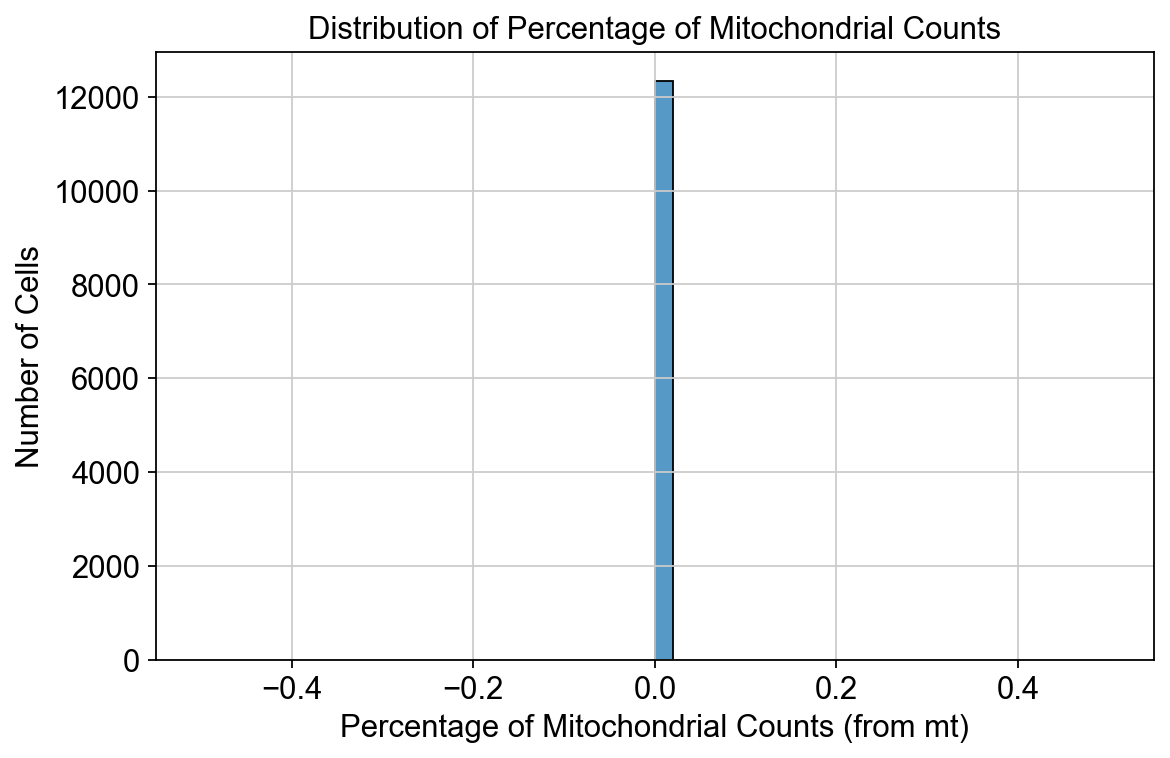


Visualizing QC metrics...
Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_93255/1928005851.py:134: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


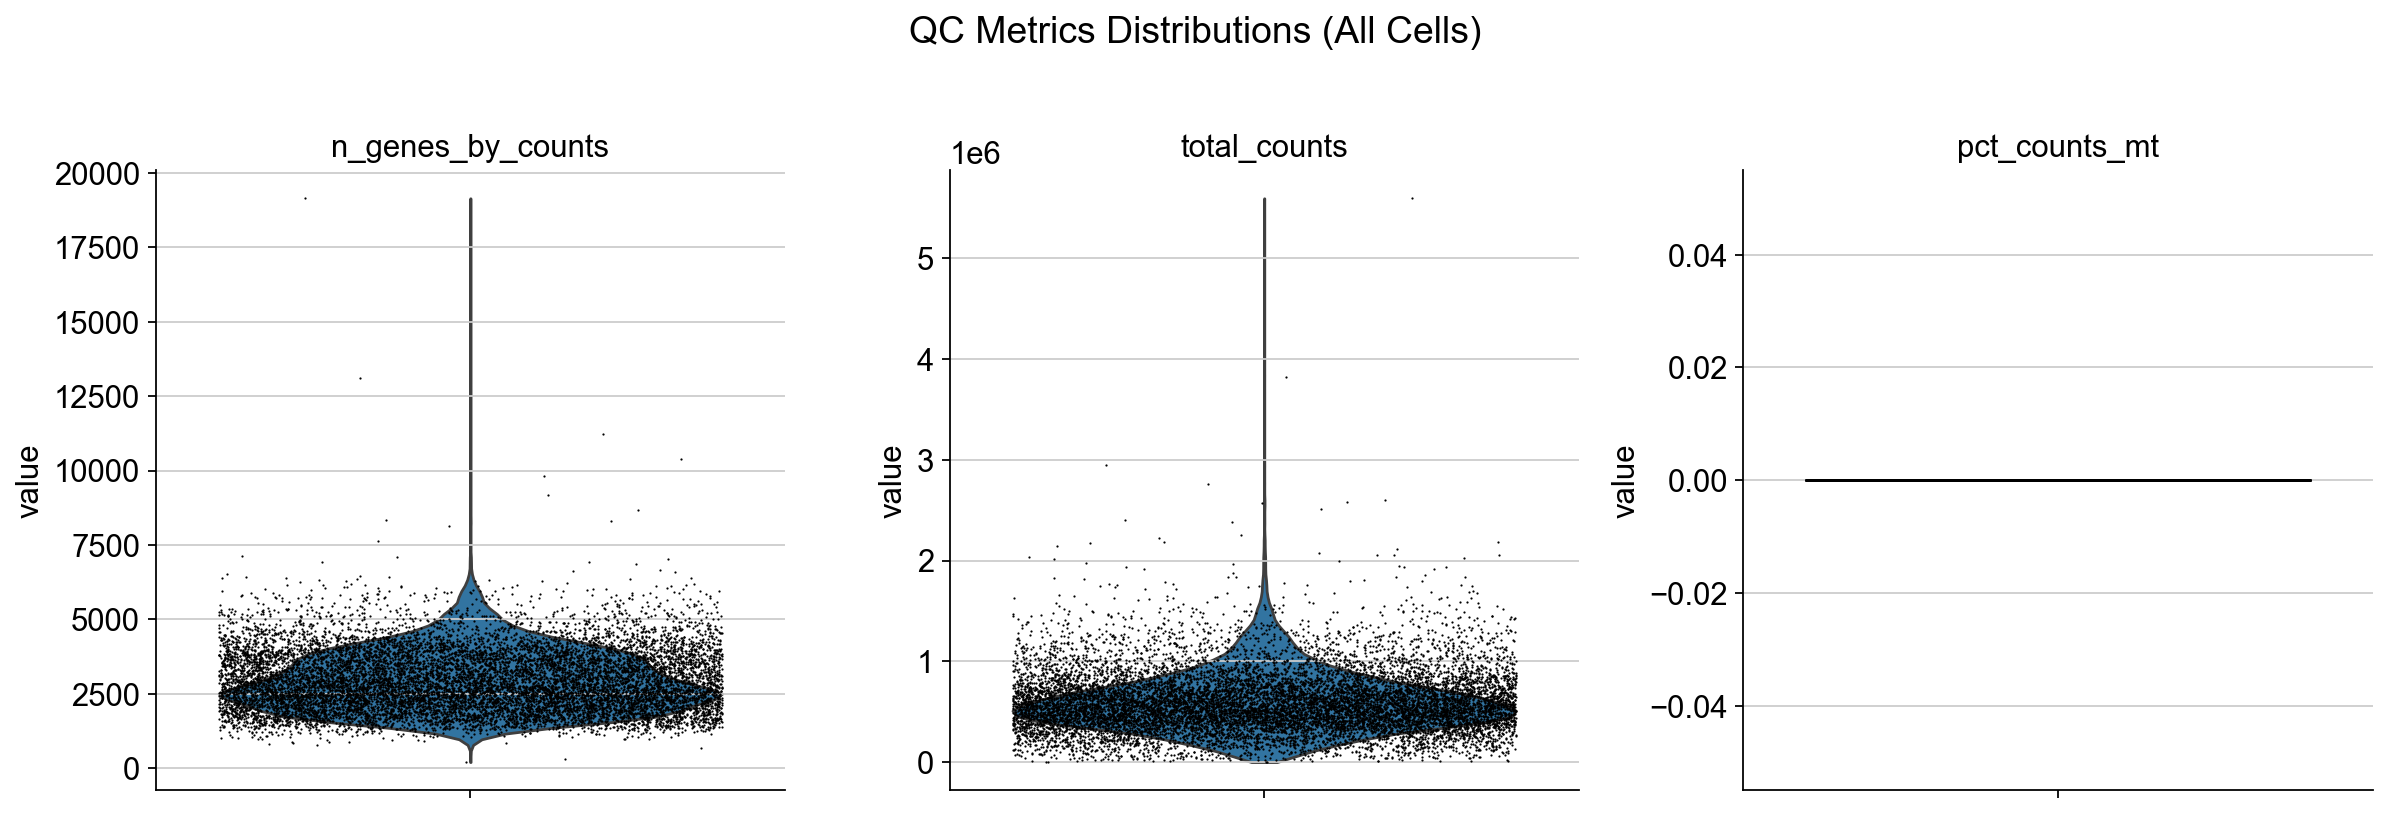


Plotting violin plots grouped by 'tissue_origin'...


/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_93255/1928005851.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


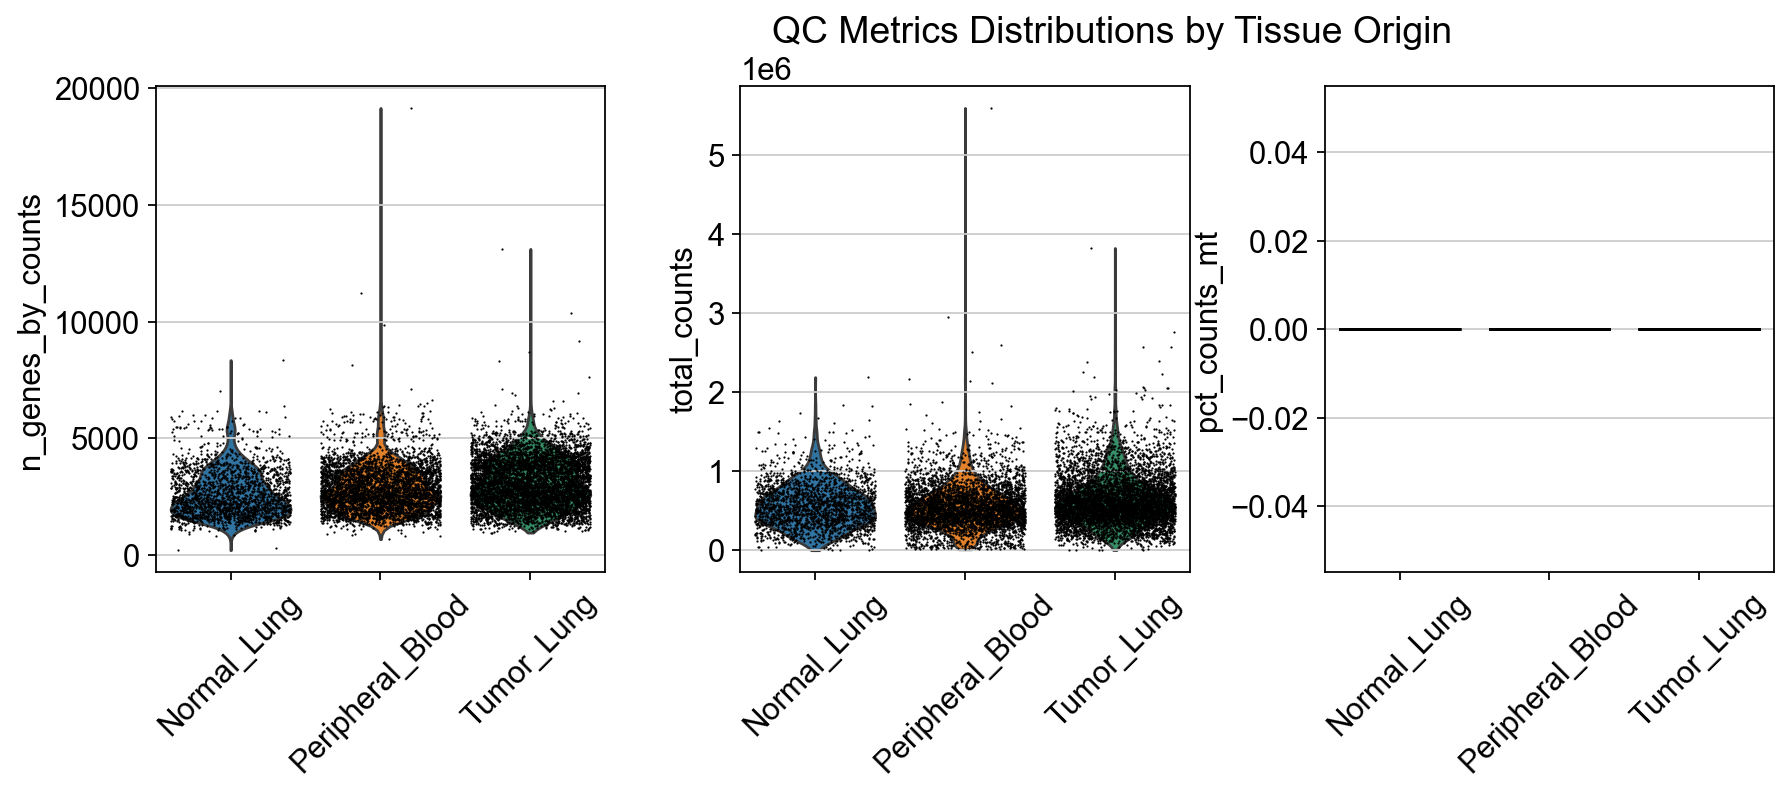


Plotting scatter plots for QC metric relationships...


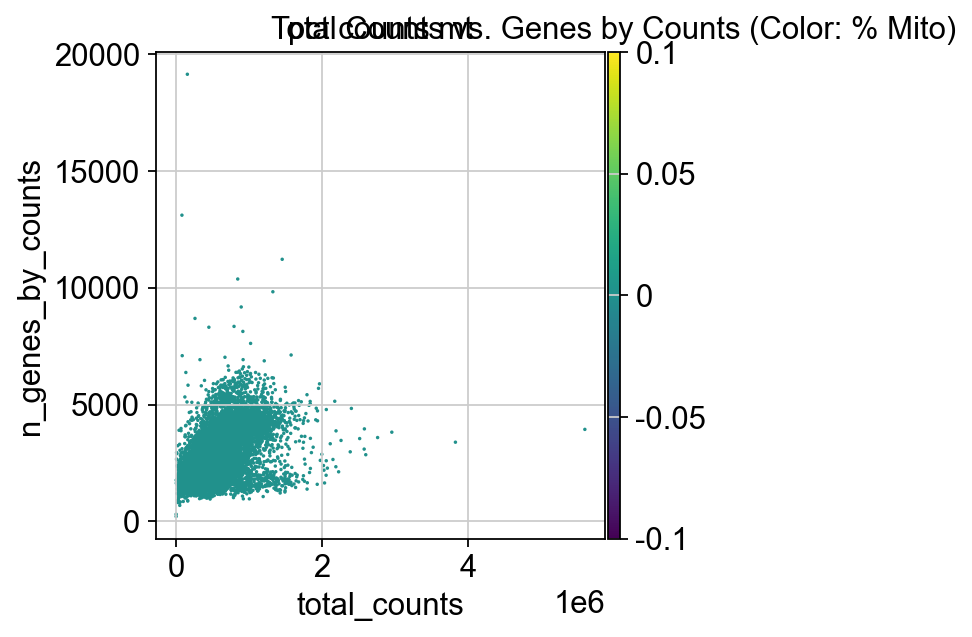

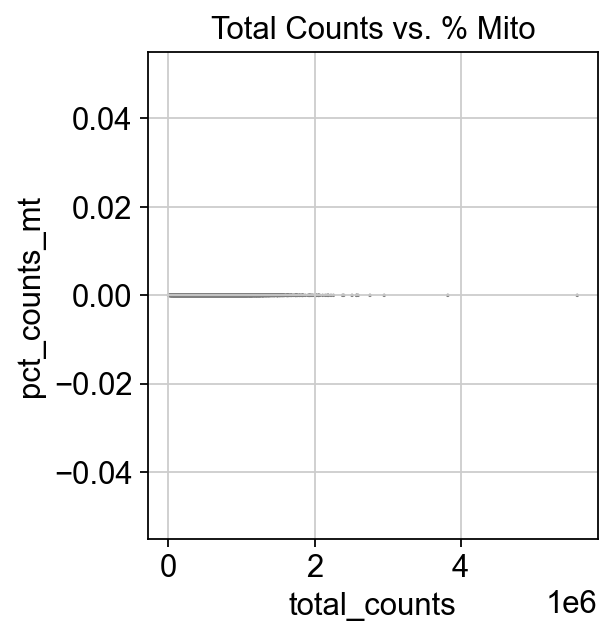

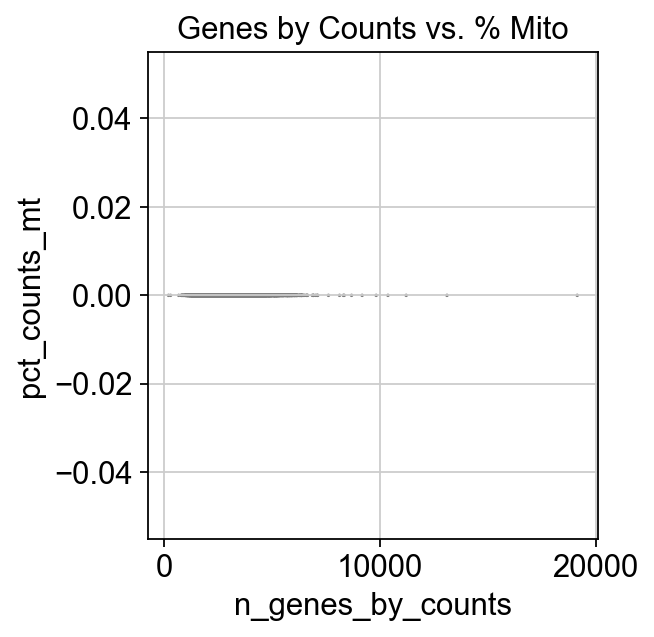

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set scanpy plotting settings for better aesthetics (optional)
sc.settings.set_figure_params(dpi=80, facecolor='white')

# --- 1. Define File Paths ---
project_dir = '/Users/mrrobot/Projects_/EDA_dashboard_GEO_dataset' # Adjust if your notebook is elsewhere
processed_data_dir = os.path.join(project_dir, 'data', 'processed')

counts_file_path = os.path.join(processed_data_dir, 'counts_matrix_raw.csv.gz')
metadata_file_path = os.path.join(processed_data_dir, 'cell_metadata_basic.csv')

# --- 2. Load Data ---
counts_df = None
basic_metadata_df = None
adata = None # Initialize adata to None

try:
    print(f"Attempting to load counts from: {counts_file_path}")
    counts_df = pd.read_csv(counts_file_path, index_col=0, compression='gzip')
    
    print(f"Attempting to load metadata from: {metadata_file_path}")
    basic_metadata_df = pd.read_csv(metadata_file_path, index_col=0)

    print("\nSuccessfully loaded counts_df and basic_metadata_df.")
    print(f"counts_df shape: {counts_df.shape}")
    print(f"basic_metadata_df shape: {basic_metadata_df.shape}")

    # --- 3. Create AnnData Object ---
    aligned_metadata_df = basic_metadata_df.loc[counts_df.columns] 
    adata = sc.AnnData(X=counts_df.T, obs=aligned_metadata_df)
    print("\nSuccessfully created AnnData object.")
    print(adata)
    
    adata.var_names_make_unique()
    print("\nMade var_names (gene names) unique.")

    # --- 4. Identify Mitochondrial Genes & Calculate QC ---
    print("\n--- Attempting to identify mitochondrial genes and calculate QC metrics ---")
    
    # Option 1: Using a predefined list (if you identify the exact names)
    # Replace this list with the actual mitochondrial gene names found in your data
    # For example, if your CLI search showed 'MTND1', 'MTCO1', etc. (no hyphen)
    # actual_mito_genes = ['MTND1', 'MTND2', 'MTND3', 'MTND4', 'MTND4L', 'MTND5', 'MTND6', 
    #                      'MTCO1', 'MTCO2', 'MTCO3', 'MTCYB', 'MTATP6', 'MTATP8', 
    #                      'MTRNR1', 'MTRNR2']
    # If they had hyphens like 'MT-ND1', use that list.
    
    # For now, since we haven't confirmed the exact names from your CLI output yet,
    # let's create an 'mt' column. If we can't find any, pct_counts_mt will be 0.
    # This allows the calculate_qc_metrics function to run without erroring on a missing qc_var.
    
    # Placeholder: Try to find genes starting with 'MT-' as a first pass
    # This didn't work before, but we need an 'mt' column for calculate_qc_metrics
    adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    num_mt_genes_found = adata.var['mt'].sum()
    
    if num_mt_genes_found == 0:
        print("WARNING: No genes found starting with 'MT-'. Trying 'MT' (no hyphen) for canonical mitochondrial genes.")
        # Attempt with no hyphen for the 15 canonical MT genes
        mito_genes_no_hyphen = [
            'MTND1', 'MTND2', 'MTND3', 'MTND4', 'MTND4L', 'MTND5', 'MTND6', 
            'MTCO1', 'MTCO2', 'MTCO3', 'MTCYB', 'MTATP6', 'MTATP8',
            'MTRNR1', 'MTRNR2'
        ]
        adata.var['mt'] = adata.var_names.isin(mito_genes_no_hyphen)
        num_mt_genes_found = adata.var['mt'].sum()
        if num_mt_genes_found == 0:
            print("WARNING: Still no canonical mitochondrial genes found (even without hyphens).")
            print("`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.")
        else:
            print(f"Found {num_mt_genes_found} mitochondrial genes using non-hyphenated canonical list.")
            print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")
    else:
        print(f"Found {num_mt_genes_found} mitochondrial genes using 'MT-' prefix.")
        print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")

    # Calculate QC metrics using scanpy's built-in function
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=['mt'], # This will use the 'mt' column defined above
        percent_top=None,
        log1p=False,
        inplace=True
    )
    # This adds 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt' to adata.obs
    
    print("\nSuccessfully calculated QC metrics.")
    print("First 5 rows of adata.obs (cell metadata with QC metrics):")
    print(adata.obs.head())

    # --- Diagnostic checks for 'pct_counts_mt' ---
    print("\nDescriptive statistics for 'pct_counts_mt':")
    print(adata.obs['pct_counts_mt'].describe())

    plt.figure(figsize=(8, 5))
    sns.histplot(adata.obs['pct_counts_mt'], bins=50, kde=False)
    plt.title('Distribution of Percentage of Mitochondrial Counts')
    plt.xlabel('Percentage of Mitochondrial Counts (from mt)')
    plt.ylabel('Number of Cells')
    plt.show()
    
except FileNotFoundError as e:
    print(f"File Not Found Error: {e}. Please ensure you saved the files from Notebook 01 into the 'data/processed/' directory.")
    adata = None 
except KeyError as e:
    print(f"KeyError during AnnData creation, alignment, or QC: {e}.")
    print("This often means cell IDs in metadata don't match counts_df columns, or a required column is missing.")
    adata = None 
except Exception as e:
    print(f"An general error occurred during data loading or initial QC setup: {e}")
    adata = None 

# --- 5. Visualize QC Metrics ---
# This section should now work if adata and its .obs columns are correctly populated
if 'adata' in locals() and adata is not None and 'n_genes_by_counts' in adata.obs.columns and 'total_counts' in adata.obs.columns and 'pct_counts_mt' in adata.obs.columns:
    print("\nVisualizing QC metrics...")

    # A. Violin plots
    print("Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions (All Cells)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Violin plots grouped by 'tissue_origin'
    print("\nPlotting violin plots grouped by 'tissue_origin'...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        groupby='tissue_origin',
        rotation=45,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions by Tissue Origin', y=1.02)
    plt.tight_layout()
    plt.show()

    # B. Scatter plots
    print("\nPlotting scatter plots for QC metric relationships...")
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. Genes by Counts (Color: % Mito)')
    plt.show()

    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. % Mito')
    plt.show()
    
    sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', show=False) 
    plt.title('Genes by Counts vs. % Mito')
    plt.show()

else:
    print("\nAnnData object 'adata' is not defined, was not successfully processed, or key QC metric columns are missing from adata.obs. Cannot visualize QC metrics.")
    if 'adata' in locals() and adata is not None:
        print("Current columns in adata.obs:", list(adata.obs.columns))

In [2]:
if num_mt_genes_found == 0:
        print("WARNING: No genes found starting with 'MT-'. Trying 'MT' (no hyphen) for canonical mitochondrial genes.")
        # ... tries non-hyphenated list ...
        if num_mt_genes_found == 0:
            print("WARNING: Still no canonical mitochondrial genes found (even without hyphens).")
            print("`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.")
        else:
            print(f"Found {num_mt_genes_found} mitochondrial genes using non-hyphenated canonical list.")
            print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")
else:
        print(f"Found {num_mt_genes_found} mitochondrial genes using 'MT-' prefix.")
        print(f"Identified MT genes: {adata.var_names[adata.var['mt']].tolist()}")

`pct_counts_mt` will be 0. You MUST resolve mitochondrial gene identification for meaningful QC.



Visualizing QC metrics...
Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_93255/372591372.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


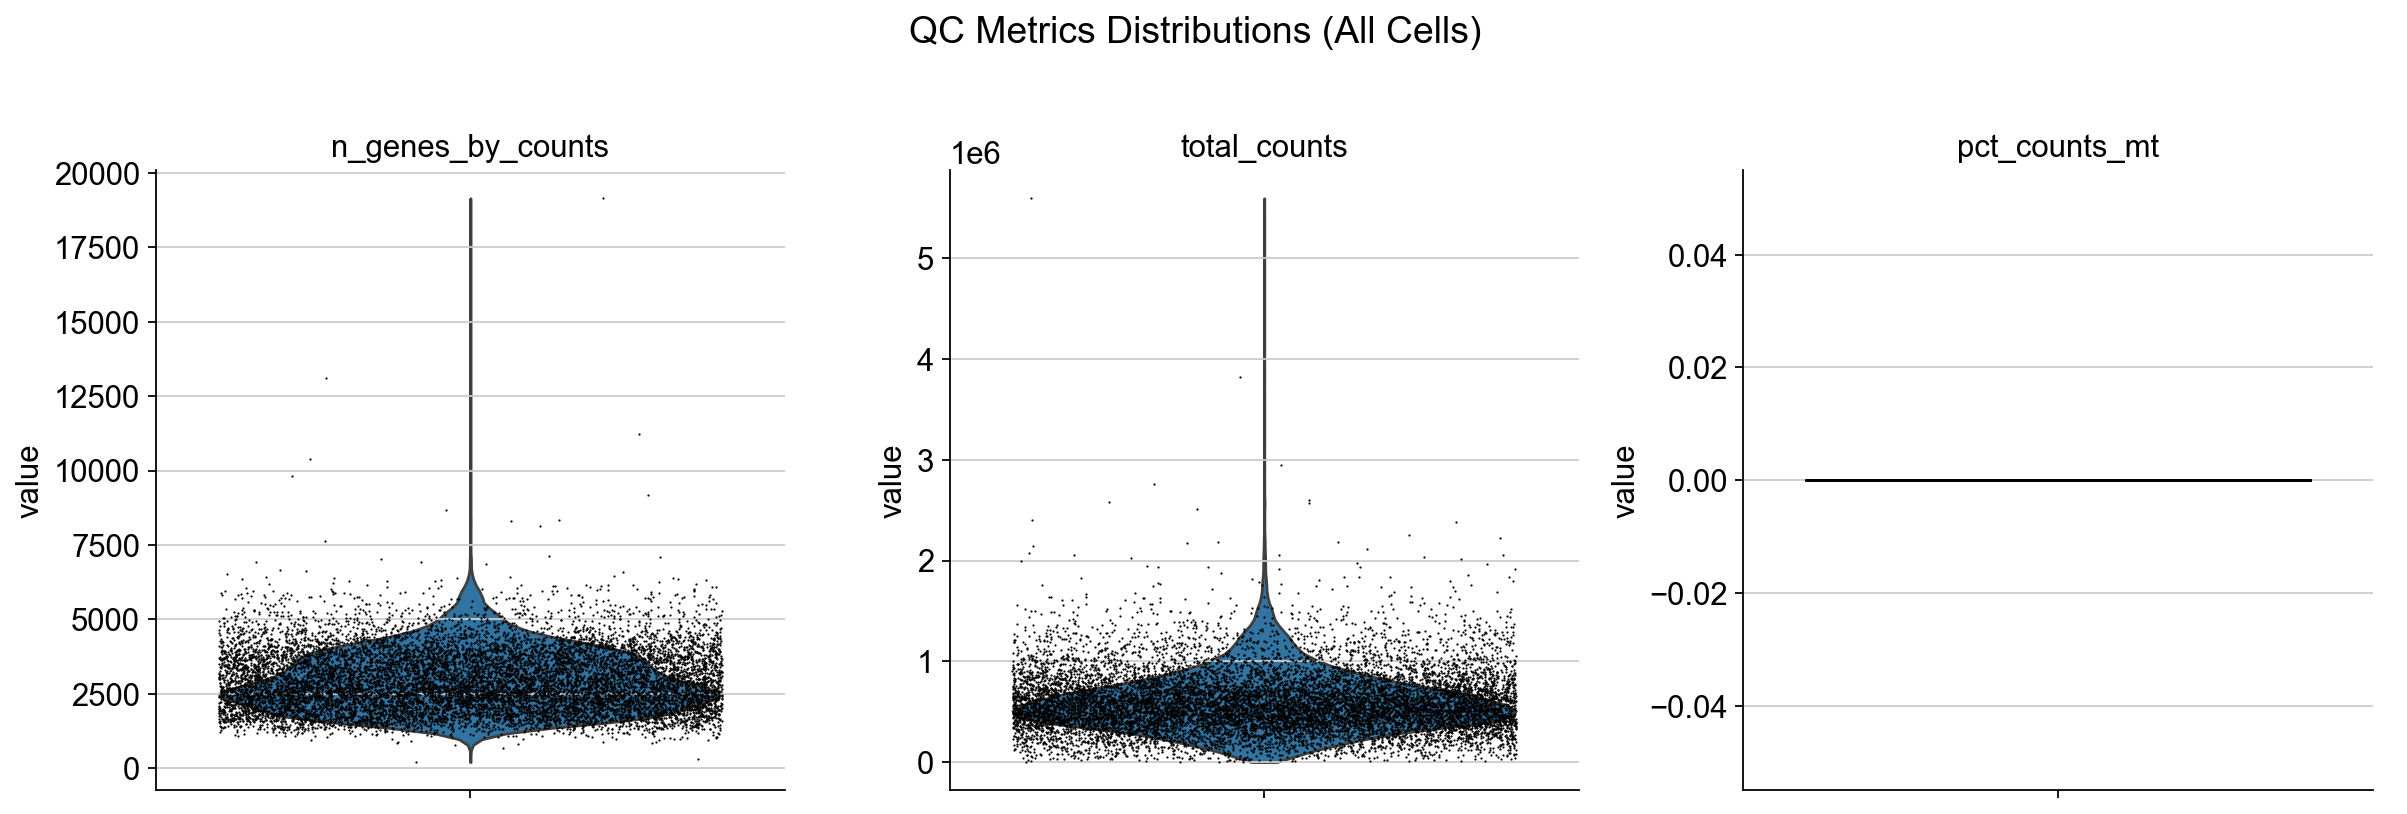


Plotting violin plots grouped by 'tissue_origin'...


/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_93255/372591372.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


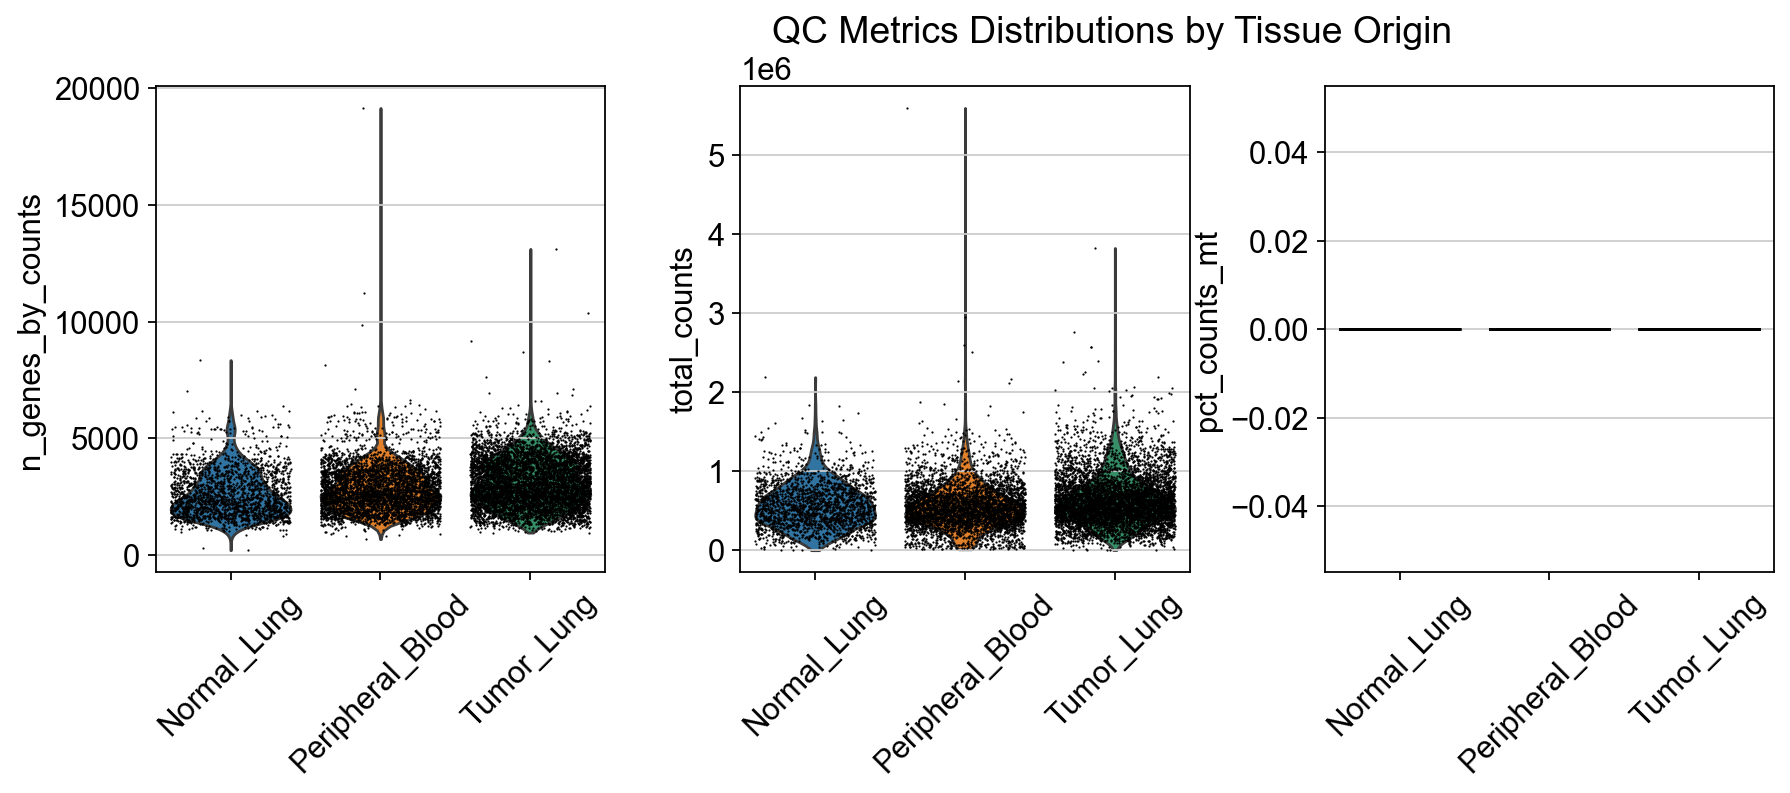


Plotting scatter plots for QC metric relationships...


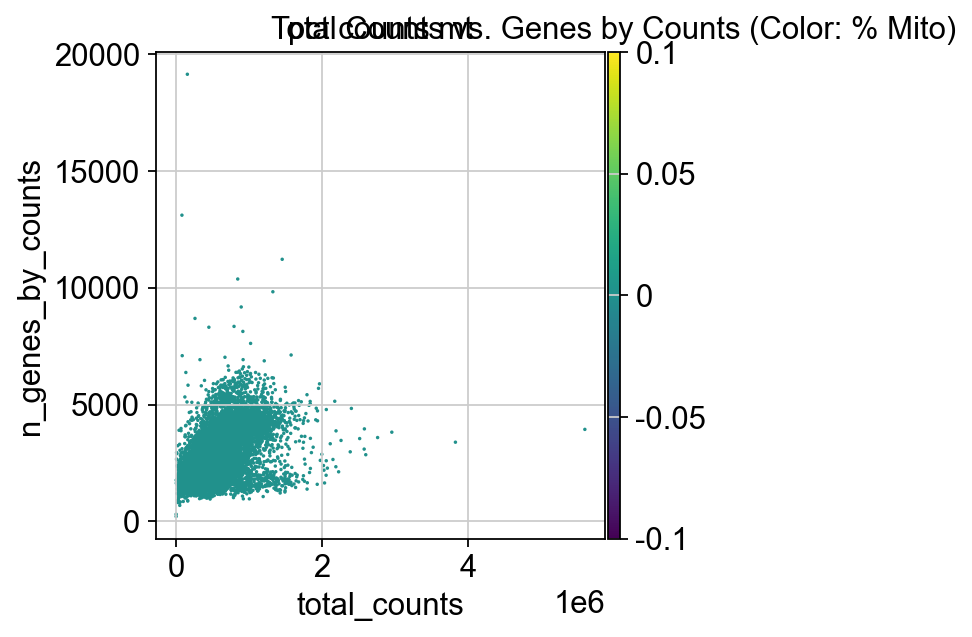

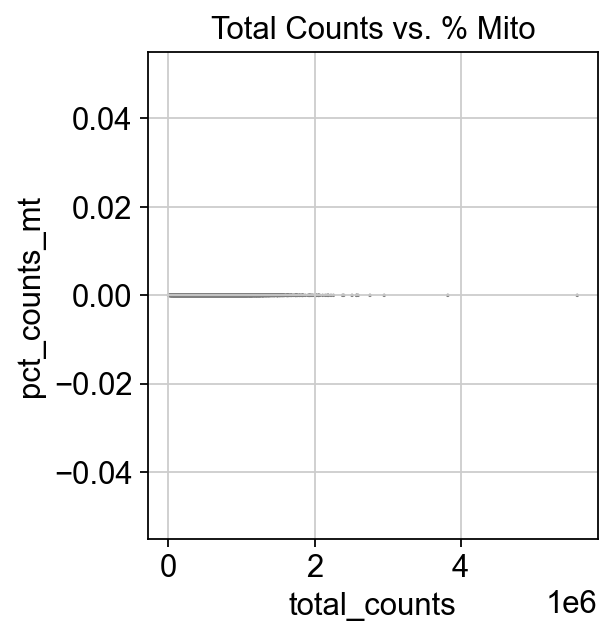

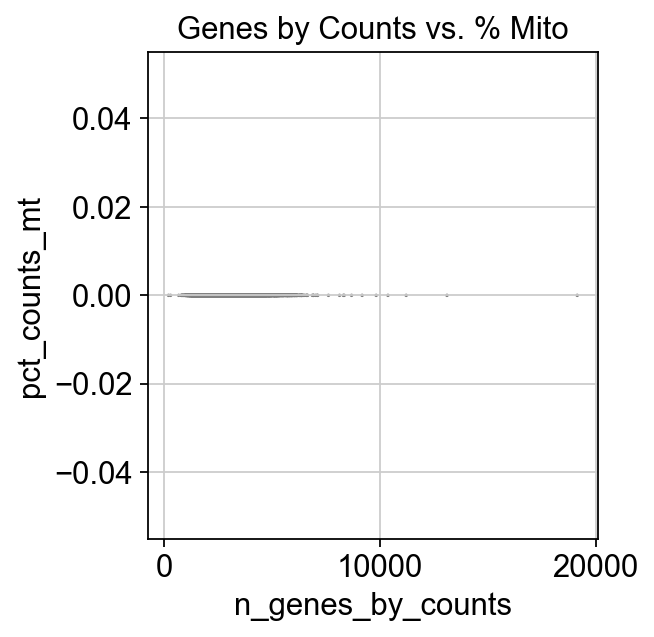

In [3]:
if 'adata' in locals() and adata is not None and 'n_genes_by_counts' in adata.obs.columns and 'total_counts' in adata.obs.columns and 'pct_counts_mt' in adata.obs.columns:
    print("\nVisualizing QC metrics...")

    # A. Violin plots
    print("Plotting violin plots for n_genes_by_counts, total_counts, and pct_counts_mt...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions (All Cells)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Violin plots grouped by 'tissue_origin'
    print("\nPlotting violin plots grouped by 'tissue_origin'...")
    sc.pl.violin(
        adata,
        ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
        jitter=0.4,
        groupby='tissue_origin',
        rotation=45,
        multi_panel=True,
        show=False
    )
    plt.suptitle('QC Metrics Distributions by Tissue Origin', y=1.02)
    plt.tight_layout()
    plt.show()

    # B. Scatter plots
    print("\nPlotting scatter plots for QC metric relationships...")
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. Genes by Counts (Color: % Mito)')
    plt.show()

    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False) 
    plt.title('Total Counts vs. % Mito')
    plt.show()
    
    sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', show=False) 
    plt.title('Genes by Counts vs. % Mito')
    plt.show()

else:
    print("\nAnnData object 'adata' is not defined, was not successfully processed, or key QC metric columns are missing from adata.obs. Cannot visualize QC metrics.")
    if 'adata' in locals() and adata is not None:
        print("Current columns in adata.obs:", list(adata.obs.columns))



--- Applying Quality Control Filters ---
Initial number of cells: 12346
Initial number of genes: 23459
Number of cells after filtering for min_genes (500): 12344
Number of cells after filtering for max_genes (6000): 12283
Number of cells after filtering for min_counts (1000): 12283
Number of cells after filtering for max_counts (4000000): 12282
Number of cells after filtering for max_mito_pct (< 100%): 12282


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:287: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Number of genes after filtering for min_cells (3): 22460

Final number of cells after QC: 12282
Final number of genes after QC: 22460

Visualizing QC metrics after filtering...


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_93255/1766564854.py:63: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


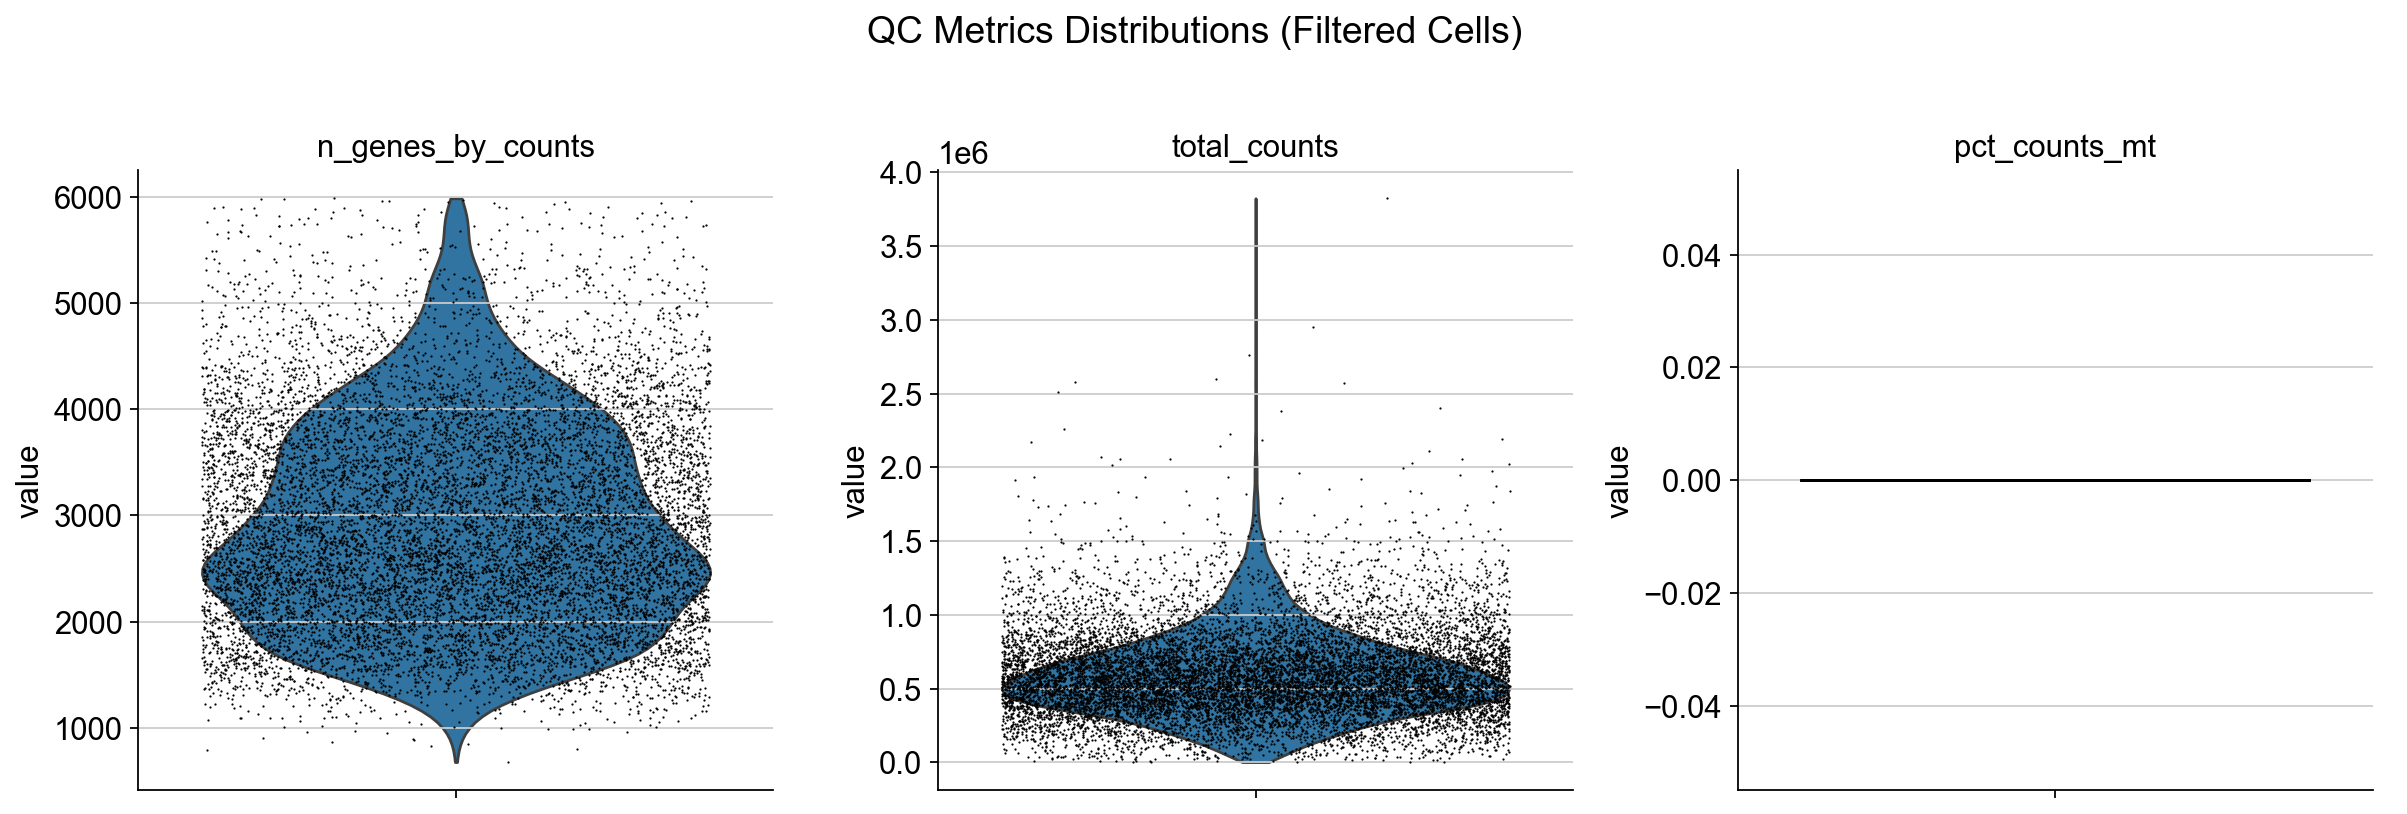

In [4]:
if 'adata' in locals() and adata is not None and 'n_genes_by_counts' in adata.obs.columns:
    print("\n--- Applying Quality Control Filters ---")
    
    # --- Define your filtering thresholds ---
    # !!! IMPORTANT: Review your plots from Cell 2 and adjust these values accordingly !!!
    min_genes = 500       # Example: Keep cells with at least 500 detected genes
    max_genes = 6000      # Example: Remove cells with more than 6000 detected genes (potential doublets)
    min_counts = 1000     # Example: Keep cells with at least 1000 total counts
    max_counts = 4000000  # Example: Remove cells with more than 4,000,000 total counts (potential doublets)
                          # Your max counts from plots seemed to go up to 5-6e6, so adjust as needed.
    max_mito_pct = 100    # Example: Keep cells with mitochondrial percentage <= 100%.
                          # Since your pct_counts_mt is currently 0, this filter won't remove any cells based on mito %.
                          # If/when you correctly identify MT genes and pct_counts_mt is non-zero,
                          # you would set this to a lower value (e.g., 5, 10, 15, or 20).

    print(f"Initial number of cells: {adata.n_obs}")
    print(f"Initial number of genes: {adata.n_vars}")

    # --- Filter cells based on number of genes ---
    sc.pp.filter_cells(adata, min_genes=min_genes)
    print(f"Number of cells after filtering for min_genes ({min_genes}): {adata.n_obs}")
    
    sc.pp.filter_cells(adata, max_genes=max_genes)
    print(f"Number of cells after filtering for max_genes ({max_genes}): {adata.n_obs}")

    # --- Filter cells based on total counts ---
    sc.pp.filter_cells(adata, min_counts=min_counts)
    print(f"Number of cells after filtering for min_counts ({min_counts}): {adata.n_obs}")

    sc.pp.filter_cells(adata, max_counts=max_counts)
    print(f"Number of cells after filtering for max_counts ({max_counts}): {adata.n_obs}")

    # --- Filter cells based on mitochondrial gene percentage ---
    # This filter will only be effective if 'pct_counts_mt' has meaningful non-zero values.
    # The condition `adata.obs['pct_counts_mt'] < max_mito_pct` creates a boolean mask.
    if 'pct_counts_mt' in adata.obs.columns:
        adata = adata[adata.obs['pct_counts_mt'] < max_mito_pct, :]
        print(f"Number of cells after filtering for max_mito_pct (< {max_mito_pct}%): {adata.n_obs}")
    else:
        print("Skipping mitochondrial percentage filter as 'pct_counts_mt' column not found in adata.obs.")

    # --- Filter genes that are expressed in too few cells ---
    # This is generally done after cell filtering.
    # A common threshold is to keep genes expressed in at least 3 cells.
    min_cells_per_gene = 3
    sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)
    print(f"Number of genes after filtering for min_cells ({min_cells_per_gene}): {adata.n_vars}")

    print(f"\nFinal number of cells after QC: {adata.n_obs}")
    print(f"Final number of genes after QC: {adata.n_vars}")

    # --- Re-visualize QC metrics on filtered data (optional but recommended) ---
    if adata.n_obs > 0: # Only plot if cells remain
        print("\nVisualizing QC metrics after filtering...")
        sc.pl.violin(
            adata,
            ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
            jitter=0.4,
            multi_panel=True,
            show=False
        )
        plt.suptitle('QC Metrics Distributions (Filtered Cells)', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("No cells remaining after filtering. Cannot visualize QC metrics.")
        
else:
    print("\nAnnData object 'adata' is not defined or key QC columns are missing. Cannot apply filters.")
    if 'adata' in locals() and adata is not None:
        print("Current columns in adata.obs:", list(adata.obs.columns))


In [5]:
if 'adata' in locals() and adata is not None and adata.n_obs > 0 and adata.n_vars > 0:
    print("\n--- Normalizing Data ---")
    
    # 1. Normalize each cell by total counts (library size correction)
    #    Each cell's counts are divided by its total counts, then multiplied by a target sum (e.g., 10,000 or 1e4).
    #    This makes counts comparable between cells with different sequencing depths.
    #    The normalized data is stored in adata.X (if you want to overwrite) or you can save the raw counts.
    #    It's common practice to save raw counts in a layer if you want to keep them.
    
    # Optional: Store raw counts in a layer if you want to keep them easily accessible
    # adata.layers["counts"] = adata.X.copy() 
    # print("Stored raw counts in adata.layers['counts']")

    sc.pp.normalize_total(adata, target_sum=1e4) # Normalizes to 10,000 counts per cell (CP10k)
    print("\nData normalized by total counts to target_sum=1e4 (CP10k).")

    # 2. Log-transform the data
    #    This helps to stabilize variance and make the data more symmetrical.
    #    Uses log(X+1) to handle zero counts.
    sc.pp.log1p(adata)
    print("Data log-transformed (log1p).")
    
    # At this point, adata.X contains the normalized and log-transformed data.
    # It's good practice to save this processed AnnData object.
    
    # Example of checking the data:
    print("\nExample of data after normalization and log-transformation (first 5 cells, first 5 genes):")
    # Note: adata.X is now cells x genes. To see it like counts_df (genes x cells), you'd transpose.
    # For direct view of adata.X:
    if isinstance(adata.X, np.ndarray):
        print(adata.X[:5, :5])
    else: # If it's a sparse matrix
        print(adata.X[:5, :5].toarray())

    print(f"\nShape of adata.X after normalization: {adata.X.shape}") # Should be (n_filtered_cells, n_filtered_genes)

else:
    print("\nAnnData object 'adata' is not defined, has no cells/genes after filtering, or an error occurred. Cannot normalize data.")



--- Normalizing Data ---

Data normalized by total counts to target_sum=1e4 (CP10k).
Data log-transformed (log1p).

Example of data after normalization and log-transformation (first 5 cells, first 5 genes):
[[0.         0.         1.4083731  0.         0.58201504]
 [0.         0.         1.9779389  0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]

Shape of adata.X after normalization: (12282, 22460)



--- Identifying Highly Variable Genes (HVGs) and Scaling Data ---


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(



Identified 2000 highly variable genes.


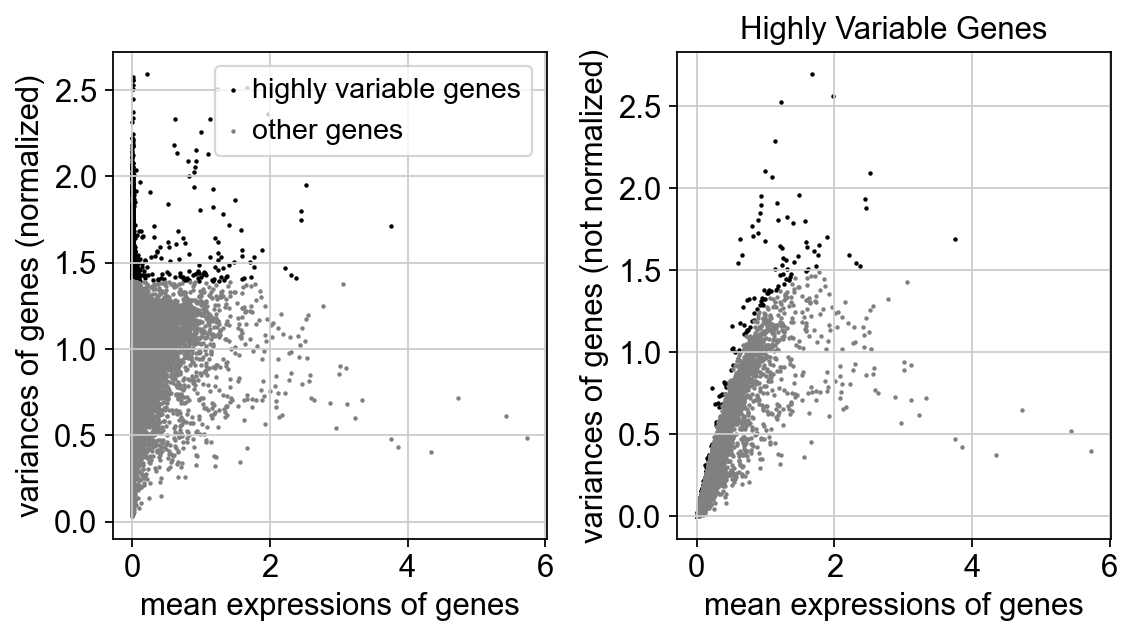


Data scaled to zero mean and unit variance (max_value=10).

Example of data after scaling (first 5 cells, first 5 genes from HVGs if subsetted, or all genes if not):
[[-0.03606904 -0.02064894 -0.04683669 -0.0135117  -0.05746967]
 [-0.03606904 -0.02064894 -0.04683669 -0.0135117  -0.05746967]
 [-0.03606904 -0.02064894 -0.04683669 -0.0135117  -0.05746967]
 [-0.03606904 -0.02064894 -0.04683669 -0.0135117  -0.05746967]
 [-0.03606904 -0.02064894 -0.04683669 -0.0135117  -0.05746967]]


In [6]:
if 'adata' in locals() and adata is not None and adata.n_obs > 0 and adata.n_vars > 0:
    print("\n--- Identifying Highly Variable Genes (HVGs) and Scaling Data ---")

    # 1. Identify Highly Variable Genes
    # This function identifies genes that show higher-than-expected variation across cells,
    # which are often the most biologically informative.
    # It considers the mean expression and dispersion (variance/mean) for each gene.
    # Parameters like min_mean, max_mean, and min_disp help to fine-tune the selection.
    # The results are stored in adata.var (e.g., adata.var['highly_variable'], adata.var['means'], adata.var['dispersions_norm']).
    
    # Default parameters often work well, but you might need to adjust them based on your data.
    # The 'flavor' parameter determines the method used. 'seurat_v3' is a common choice.
    # 'n_top_genes' can be used to select a fixed number of top HVGs.
    sc.pp.highly_variable_genes(
        adata, 
        min_mean=0.0125, 
        max_mean=3,       # These are on log-scale if data is log-transformed before this step
                          # Since our adata.X is already log-transformed from Cell 4, these are appropriate.
        min_disp=0.5, 
        n_top_genes=None, # Set to an integer (e.g., 2000 or 3000) if you want a fixed number of HVGs
        flavor='seurat_v3', # A common method for HVG selection
        subset=False      # If True, subsets adata to only HVGs. Set to False to keep all genes and mark HVGs.
                          # We will subset manually later if needed for PCA.
    )
    
    print(f"\nIdentified {adata.var['highly_variable'].sum()} highly variable genes.")
    
    # Visualize highly variable genes
    sc.pl.highly_variable_genes(adata, show=False)
    plt.title('Highly Variable Genes')
    plt.show()

    # 2. (Optional) Subset adata to only highly variable genes for PCA and other downstream steps
    #    This is a common practice to focus on the most informative genes and reduce computational load.
    #    However, for some analyses (like DGE), you might want to use all genes.
    # adata_hvg = adata[:, adata.var.highly_variable].copy()
    # print(f"Created a subset anndata object 'adata_hvg' with only HVGs: {adata_hvg.n_vars} genes")
    # For now, we'll keep all genes in 'adata' and use the 'highly_variable' flag later if needed.

    # 3. Scale the Data
    #    This step scales the data to have zero mean and unit variance for each gene.
    #    It's typically applied only to the highly variable genes if you've subsetted them.
    #    If applied to the whole adata object, it will scale all genes, but PCA will typically
    #    only be run on HVGs.
    #    The `max_value` parameter clips extreme values to prevent them from dominating.
    
    # We will scale only the HVGs. It's good practice to do this on a copy if you
    # want to keep the original log-normalized values for HVGs.
    # However, sc.pp.scale modifies adata.X inplace by default.
    # If you want to scale all genes: sc.pp.scale(adata, max_value=10)
    # If you want to scale only HVGs and keep other genes as they are in adata.X,
    # it's often done by first subsetting, scaling, and then potentially merging back or using the subset.
    # For typical PCA workflows, you scale the data that will go into PCA.
    
    # Let's scale all genes in adata.X for now. PCA will later be run on HVGs.
    # If you saved raw counts in adata.layers['counts'], this scaling won't affect that layer.
    sc.pp.scale(adata, max_value=10)
    print("\nData scaled to zero mean and unit variance (max_value=10).")
    
    # Check an example of scaled data
    print("\nExample of data after scaling (first 5 cells, first 5 genes from HVGs if subsetted, or all genes if not):")
    # Find some HVGs to display if possible
    hvg_sample_indices = np.where(adata.var['highly_variable'])[0]
    if len(hvg_sample_indices) >= 5:
        genes_to_show_indices = hvg_sample_indices[:5]
    elif adata.n_vars >= 5: # Fallback to first 5 genes if not enough HVGs
        genes_to_show_indices = range(5)
    else:
        genes_to_show_indices = range(adata.n_vars)

    if isinstance(adata.X, np.ndarray):
        print(adata.X[:5, genes_to_show_indices])
    else: # If it's a sparse matrix
        print(adata.X[:5, genes_to_show_indices].toarray())

else:
    print("\nAnnData object 'adata' is not defined or has no cells/genes. Cannot identify HVGs or scale data.")



--- Performing Principal Component Analysis (PCA) ---


/Users/mrrobot/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)



PCA completed.
PCA results are stored in adata.obsm['X_pca'] (cell embeddings) and adata.varm['PCs'] (gene loadings).
Shape of X_pca: (12282, 50)


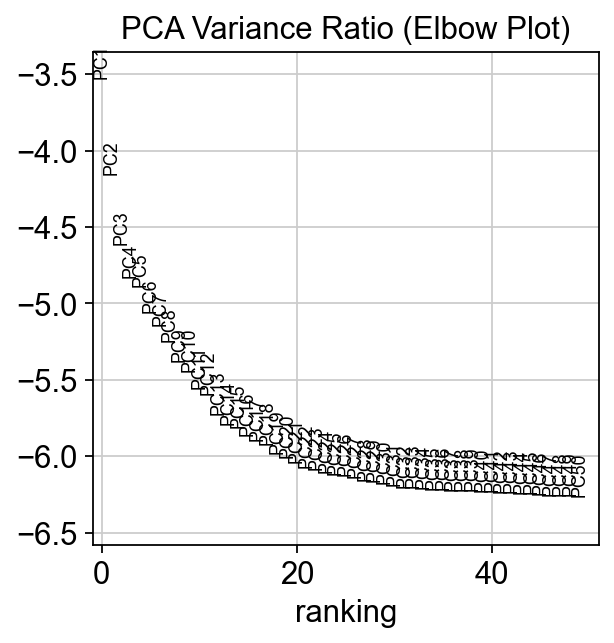


Plotting PCA scatter plots...


/var/folders/mx/ttczf76577z53ygmmv93kfzw0000gn/T/ipykernel_93255/3365813887.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


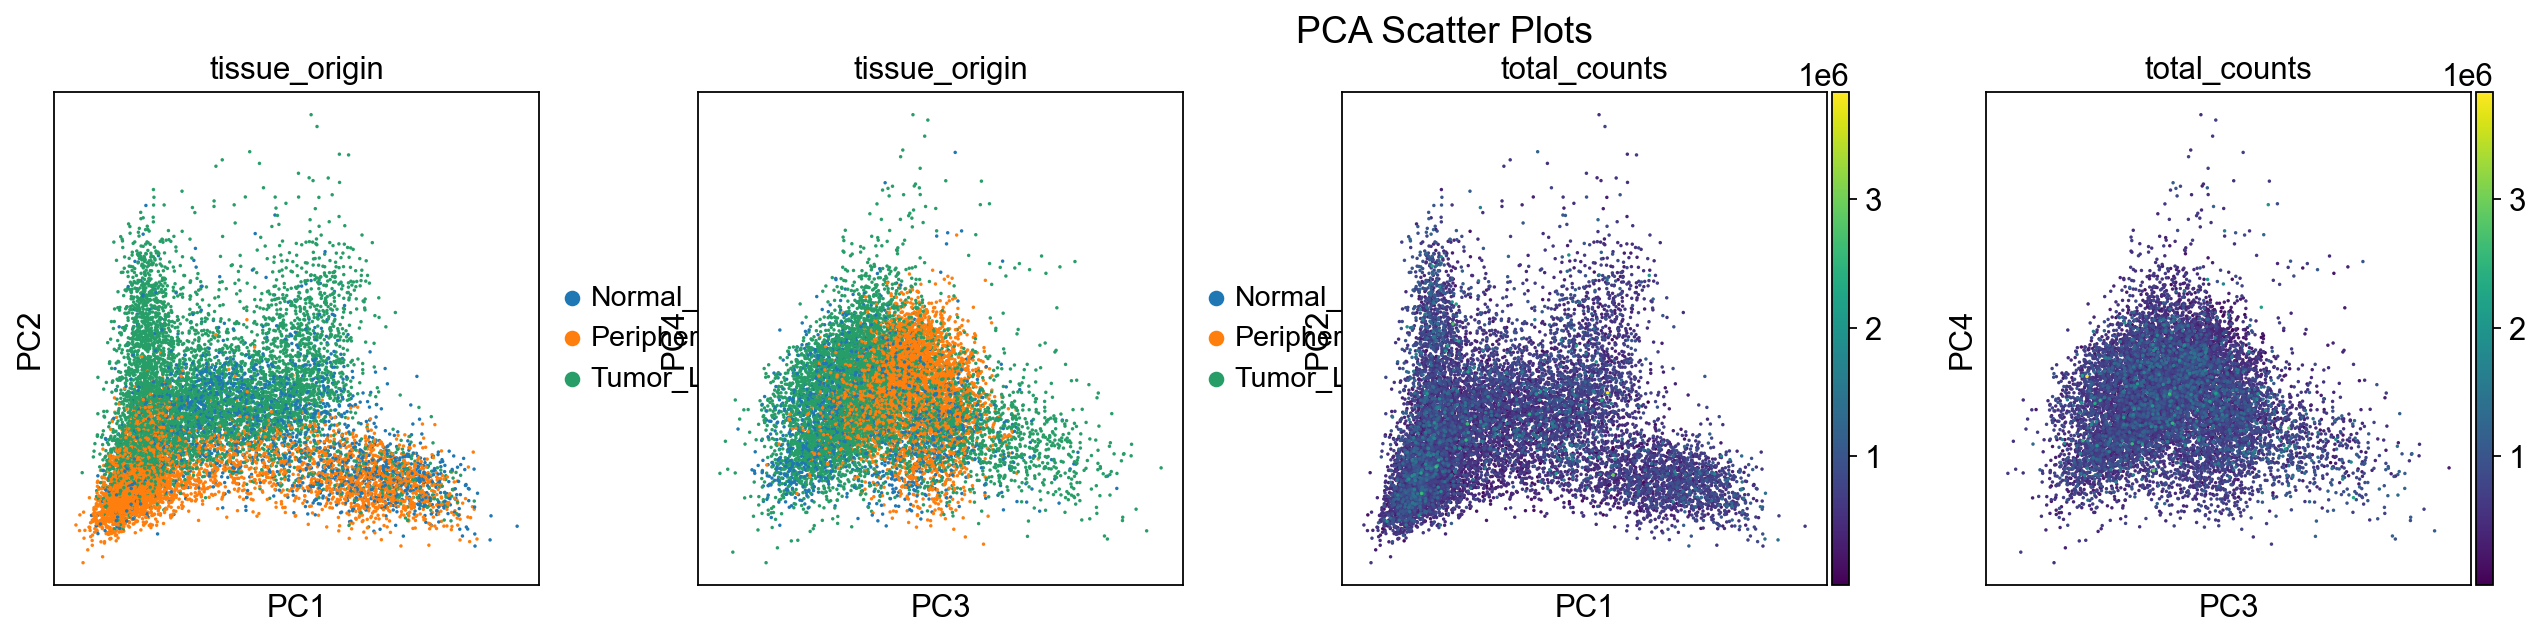

In [8]:
if 'adata' in locals() and adata is not None and adata.n_obs > 0 and adata.n_vars > 0:
    print("\n--- Performing Principal Component Analysis (PCA) ---")

    # 1. Run PCA
    # By default, sc.tl.pca will use the data in adata.X (which should be scaled).
    # It will also use adata.var['highly_variable'] to subset to HVGs if it exists.
    # n_comps: Number of principal components to compute. 50 is a common starting point.
    # svd_solver: Algorithm for PCA. 'arpack' often works well for scRNA-seq.
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    
    print("\nPCA completed.")
    print("PCA results are stored in adata.obsm['X_pca'] (cell embeddings) and adata.varm['PCs'] (gene loadings).")
    print(f"Shape of X_pca: {adata.obsm['X_pca'].shape}") # Should be (n_cells, n_comps)

    # 2. Visualize PCA results
    # A. Variance Ratio Plot (Elbow Plot)
    # This plot helps to decide how many PCs to use for downstream analysis.
    # Look for an "elbow" or a point where adding more PCs doesn't explain much more variance.
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, show=False)
    plt.title('PCA Variance Ratio (Elbow Plot)')
    plt.show()

    # B. Scatter plot of first few PCs
    # You can color by metadata, e.g., 'tissue_origin' or 'total_counts'
    print("\nPlotting PCA scatter plots...")
    # Corrected line: removed n_comps when components is a list of strings
    sc.pl.pca(adata, color=['tissue_origin', 'total_counts'], components=['1,2', '3,4'], show=False)
    plt.suptitle('PCA Scatter Plots', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # You might also want to save the adata object after PCA
    # processed_adata_pca_path = os.path.join(processed_data_dir, 'adata_processed_pca.h5ad')
    # try:
    #     adata.write_h5ad(processed_adata_pca_path)
    #     print(f"\nSuccessfully saved AnnData object after PCA to: {processed_adata_pca_path}")
    # except Exception as e:
    #     print(f"Error saving AnnData object after PCA: {e}")

else:
    print("\nAnnData object 'adata' is not defined or has no cells/genes. Cannot perform PCA.")


In [9]:
# === Cell 7: Neighborhood Graph, UMAP, and Clustering (Section 10) ===
if 'adata' in locals() and adata is not None and 'X_pca' in adata.obsm:
    print("\n--- Computing Neighborhood Graph, UMAP, and Clustering ---")

    # 1. Compute Neighborhood Graph
    # This constructs a k-nearest-neighbor graph based on the PCA representation.
    # n_neighbors: Number of neighbors to consider for each cell. 15 is a common default.
    # n_pcs: Number of principal components to use. Choose based on your elbow plot (e.g., 10-30).
    #        Let's use 20 PCs as an example, based on typical elbow plot observations.
    n_pcs_to_use = 20 
    print(f"Computing neighborhood graph using the top {n_pcs_to_use} PCs...")
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs_to_use)
    print("Neighborhood graph computed. Stored in adata.obsp['distances'] and adata.obsp['connectivities'].")

    # 2. Compute UMAP (Uniform Manifold Approximation and Projection)
    # This creates a 2D (or 3D) embedding for visualization, based on the neighborhood graph.
    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata)
    print("UMAP embedding computed. Stored in adata.obsm['X_umap'].")

    # 3. Perform Clustering (e.g., Leiden algorithm)
    # This groups cells into clusters based on the neighborhood graph.
    # Resolution parameter influences the number of clusters found (higher resolution -> more clusters).
    print("\nPerforming Leiden clustering...")
    sc.tl.leiden(adata, resolution=0.5) # 0.5 is an example resolution, you might need to tune this
    print("Leiden clustering completed. Cluster labels stored in adata.obs['leiden'].")

    # 4. Visualize UMAP
    # Color by different metadata to see patterns.
    print("\nPlotting UMAP...")
    sc.pl.umap(adata, color=['leiden', 'tissue_origin', 'patient_id'], show=False, legend_loc='on data')
    plt.suptitle('UMAP Embeddings', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # You can also color by expression of specific genes on the UMAP
    # Example (replace with genes of interest if you know some):
    # if adata.n_vars > 20: # Check if there are enough genes to pick from
    #     example_genes_to_plot = adata.var_names[:3].tolist() # Plot first 3 genes as an example
    #     sc.pl.umap(adata, color=example_genes_to_plot, show=False)
    #     plt.suptitle(f'UMAP colored by example genes: {", ".join(example_genes_to_plot)}', y=1.02)
    #     plt.tight_layout()
    #     plt.show()

    # Save the AnnData object after these steps
    # processed_adata_clustered_path = os.path.join(processed_data_dir, 'adata_processed_clustered.h5ad')
    # try:
    #     adata.write_h5ad(processed_adata_clustered_path)
    #     print(f"\nSuccessfully saved AnnData object after clustering to: {processed_adata_clustered_path}")
    # except Exception as e:
    #     print(f"Error saving AnnData object after clustering: {e}")

else:
    print("\nAnnData object 'adata' is not defined or PCA has not been run. Cannot compute neighborhood graph, UMAP, or cluster.")
    if 'adata' in locals() and adata is not None:
        print("Available obsm keys:", list(adata.obsm.keys()))

# === End of Cell 7 ===


--- Computing Neighborhood Graph, UMAP, and Clustering ---
Computing neighborhood graph using the top 20 PCs...
Neighborhood graph computed. Stored in adata.obsp['distances'] and adata.obsp['connectivities'].

Computing UMAP embedding...
UMAP embedding computed. Stored in adata.obsm['X_umap'].

Performing Leiden clustering...


ImportError: Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`.